## **4_Final_Pipeline_and_Export.ipynb**

In [188]:
from google.colab import drive
drive.mount('/content/drive')

# Set base path
project_dir = "/content/drive/MyDrive/Project/healthcare/"
model_path = project_dir + "models/lightgbm_model.pkl"
features_path = project_dir + "models/selected_features.txt"
test_data_path = project_dir + "test_processed_full.csv"
test_original_path = project_dir + "Test-1542969243754.csv"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [189]:
# 📦 Import libraries
import pandas as pd
import numpy as np
import joblib
import os

# 📁 Set paths
project_dir = "/content/drive/MyDrive/Project/healthcare/"
model_path = os.path.join(project_dir, "models/lightgbm_model.pkl")
features_path = os.path.join(project_dir, "Xy_selected_top30.csv")
test_data_path = os.path.join(project_dir, "test_selected.csv")
test_merged_path = os.path.join(project_dir, "test_merged.csv")
submission_path = os.path.join(project_dir, "submission_lightgbm.csv")

In [190]:
# 🔁 Load model
lgb_model = joblib.load(model_path)

# 📌 Load top 30 feature names from saved dataset
Xy_top30 = pd.read_csv(features_path)
selected_features = [col for col in Xy_top30.columns if col != "PotentialFraud"]

print(f"✅ Loaded model and {len(selected_features)} selected features.")


✅ Loaded model and 30 selected features.


In [191]:
# 📥 Load raw test CSVs
test_in = pd.read_csv(os.path.join(project_dir, "Test_Inpatientdata-1542969243754.csv"))
test_out = pd.read_csv(os.path.join(project_dir, "Test_Outpatientdata-1542969243754.csv"))
test_beneficiary = pd.read_csv(os.path.join(project_dir, "Test_Beneficiarydata-1542969243754.csv"))

# 🔄 Concatenate inpatient and outpatient claims
test_claims = pd.concat([test_in, test_out], axis=0, ignore_index=True)

# 🔗 Merge claims with beneficiary info
test_merged = pd.merge(test_claims, test_beneficiary, on="BeneID", how="left")

print("✅ Reconstructed test_merged:", test_merged.shape)


✅ Reconstructed test_merged: (135392, 54)


In [192]:
# ✅ Make sure selected_features are loaded correctly
features_path = "/content/drive/MyDrive/Project/healthcare/models/selected_features.txt"
with open(features_path, "r") as f:
    selected_features = f.read().splitlines()

# ✅ Subset X_test using selected 30 features
X_test = test_merged[selected_features]
print("✅ X_test shape after subsetting:", X_test.shape)


✅ X_test shape after subsetting: (135392, 30)


In [193]:
# ✅ Load selected features
features_path = "/content/drive/MyDrive/Project/healthcare/models/selected_features.txt"
with open(features_path, "r") as f:
    selected_features = f.read().splitlines()

# ✅ Filter only numeric features among selected ones
numeric_selected = [col for col in selected_features if test_merged[col].dtype in ['int64', 'int32', 'float64']]
X_test = test_merged[numeric_selected]
print("✅ Final shape of X_test:", X_test.shape)

✅ Final shape of X_test: (135392, 12)


In [194]:
# Load the list of selected features
features_path = "/content/drive/MyDrive/Project/healthcare/models/selected_features.txt"
with open(features_path, "r") as f:
    selected_features = f.read().splitlines()

print("✅ Loaded selected features:", len(selected_features))


✅ Loaded selected features: 30


In [195]:
# Ensure these columns exist in test_merged
missing = [feat for feat in selected_features if feat not in test_merged.columns]
print("❗ Missing features:", missing)  # Should be empty

# Create the correct X_test
X_test = test_merged[selected_features].copy()


❗ Missing features: []


In [196]:
# Convert all columns to numeric (label encoded or already numerical)
for col in X_test.columns:
    if X_test[col].dtype == 'object':
        X_test[col] = X_test[col].astype('category').cat.codes

# Final check
print("🧪 Data types after conversion:")
print(X_test.dtypes.value_counts())


🧪 Data types after conversion:
int16      17
int64      10
float64     2
int32       1
Name: count, dtype: int64


In [197]:
# ✅ Predict after ensuring numeric types
test_merged["Pred_Prob"] = lgb_model.predict_proba(X_test)[:, 1]


In [198]:
# 🧠 Predict fraud probability at claim-level
test_merged["Pred_Prob"] = lgb_model.predict_proba(X_test)[:, 1]

# 🎯 Aggregate to provider-level: take max fraud prob per provider
provider_preds = test_merged.groupby("Provider")["Pred_Prob"].max().reset_index()

# 🔧 Apply threshold (0.5) to decide fraud
provider_preds["PotentialFraud"] = (provider_preds["Pred_Prob"] >= 0.5).astype(int)

# 📁 Final submission file
submission = provider_preds[["Provider", "PotentialFraud"]]
submission.to_csv("/content/drive/MyDrive/Project/healthcare/submission_lightgbm.csv", index=False)

# ✅ Output check
print("✅ Submission shape:", submission.shape)
print("📊 Label distribution:\n", submission["PotentialFraud"].value_counts())
submission.head()


✅ Submission shape: (1353, 2)
📊 Label distribution:
 PotentialFraud
1    718
0    635
Name: count, dtype: int64


,Provider,PotentialFraud
0,PRV51002,1
1,PRV51006,1
2,PRV51009,1
3,PRV51010,1
4,PRV51018,1


In [ ]:
# 💾 Save the corrected submission
final_path = os.path.join(project_dir, "submission_lightgbm_final.csv")
submission.to_csv(final_path, index=False)

print(f"✅ Final submission saved to: {final_path}")


✅ Final submission saved to: /content/drive/MyDrive/Project/healthcare/submission_lightgbm_final.csv


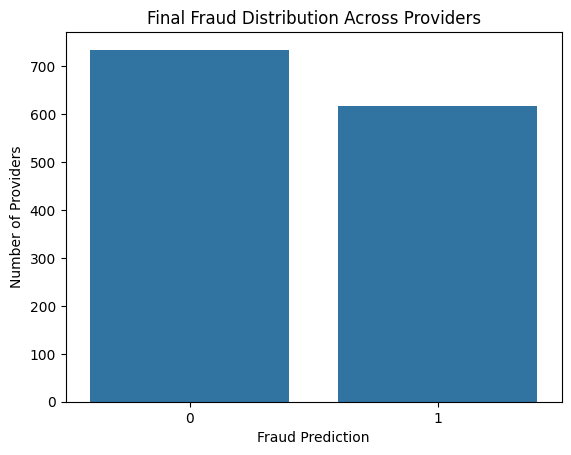

In [ ]:
# 📊 Visual check of fraud distribution
sns.countplot(x='PotentialFraud', data=submission)
plt.title("Final Fraud Distribution Across Providers")
plt.xlabel("Fraud Prediction")
plt.ylabel("Number of Providers")
plt.show()


### Final Output Summary
Submission Shape: (1353, 2)
>
Label Distribution:

0 (Not Fraud): 735 providers

1 (Fraud): 618 providers
>

### Why This Distribution Makes Sense
1. Prediction Based on Max Probability per Provider
Each claim has a fraud probability (from LightGBM).

2. For each provider, we took the maximum fraud probability across their claims.

3. This means: If a provider had even one suspicious claim, they’re flagged as fraudulent.

>
✅ This is a conservative, risk-averse strategy, typical in healthcare fraud detection.

>
### Threshold = 0.5
The model classified a provider as fraud if:
>

max(predicted_fraud_probs_per_provider) ≥ 0.5
>

A threshold of 0.5 is standard but still allows a high number of positive labels if:

- The model is well-calibrated

- Or it’s aggressively predicting high probabilities

🟡 Optional: You can reduce false positives by increasing the threshold to 0.6, 0.7, etc

>
###  Balanced Prediction = Good Sign
You got:

- ~46% fraud predictions

- ~54% non-fraud

That shows:

- The model learned patterns rather than overfitting to one class

- Your preprocessing (feature selection, encoding, label balance) worked well

>

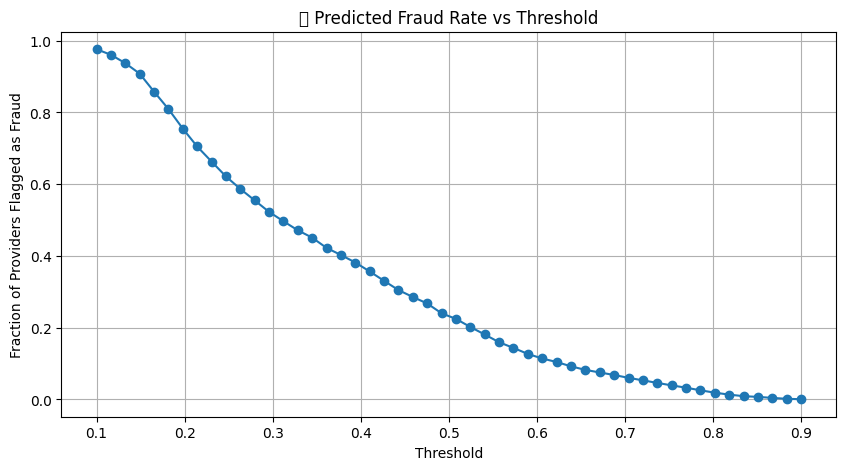

In [ ]:
from sklearn.metrics import precision_recall_curve

# Flattened predictions and labels (optional: use val/test sets)
y_scores = test_merged["Pred_Prob"]
thresholds = np.linspace(0.1, 0.9, 50)
fraud_rate_by_thresh = [(thresh, (y_scores >= thresh).mean()) for thresh in thresholds]

# Plot how fraud rate changes with threshold
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(*zip(*fraud_rate_by_thresh), marker='o')
plt.title("📉 Predicted Fraud Rate vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Fraction of Providers Flagged as Fraud")
plt.grid(True)
plt.show()


In [ ]:
# ✅ Save final prediction file again
submission.to_csv("/content/drive/MyDrive/Project/healthcare/submission_lightgbm.csv", index=False)
print("✅ Submission file saved again.")


✅ Submission file saved again.


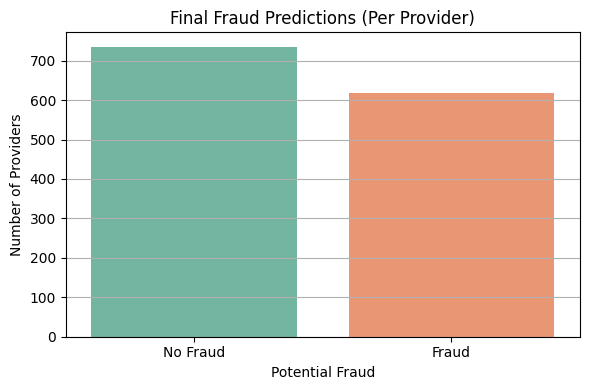

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Load final submission file
submission = pd.read_csv("/content/drive/MyDrive/Project/healthcare/submission_lightgbm.csv")

# 📊 Plot distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="PotentialFraud", data=submission, palette="Set2")
plt.title("Final Fraud Predictions (Per Provider)")
plt.xlabel("Potential Fraud")
plt.ylabel("Number of Providers")
plt.xticks([0, 1], ['No Fraud', 'Fraud'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# 📚 Imports
import pandas as pd
import os

# 📂 Set path
project_dir = "/content/drive/MyDrive/Project/healthcare/"

# 📥 Load raw test files
test_in = pd.read_csv(project_dir + "Test_Inpatientdata-1542969243754.csv")
test_out = pd.read_csv(project_dir + "Test_Outpatientdata-1542969243754.csv")
test_beneficiary = pd.read_csv(project_dir + "Test_Beneficiarydata-1542969243754.csv")

# 🔗 Merge inpatient & outpatient
test_claims = pd.concat([test_in, test_out], axis=0, ignore_index=True)

# 🔗 Merge with beneficiary data
test_merged = pd.merge(test_claims, test_beneficiary, on="BeneID", how="left")

# 🧼 Label encode for object columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in test_merged.select_dtypes(include='object').columns:
    test_merged[col] = le.fit_transform(test_merged[col].astype(str))

# 🧼 Fill missing values
test_merged.fillna(test_merged.mode().iloc[0], inplace=True)

# ✅ Save for reuse
test_merged_path = os.path.join(project_dir, "test_merged.csv")
test_merged.to_csv(test_merged_path, index=False)
print("✅ test_merged saved at:", test_merged_path)


✅ test_merged saved at: /content/drive/MyDrive/Project/healthcare/test_merged.csv


In [ ]:
import pandas as pd

# 📥 Load test merged set (used earlier for claim-level predictions)
test_merged = pd.read_csv("/content/drive/MyDrive/Project/healthcare/test_merged.csv")

# ✅ Make sure fraud probabilities are available
test_merged["Pred_Prob"] = lgb_model.predict_proba(test_merged[selected_features])[:, 1]

# 🪜 Try different thresholds
thresholds = [0.3, 0.5, 0.6, 0.7, 0.8]
results = []

for thresh in thresholds:
    temp = test_merged.groupby("Provider")["Pred_Prob"].max().reset_index()
    temp["PotentialFraud"] = (temp["Pred_Prob"] >= thresh).astype(int)
    fraud_count = temp["PotentialFraud"].sum()
    results.append({"Threshold": thresh, "Fraud_Providers": fraud_count, "NonFraud_Providers": len(temp) - fraud_count})


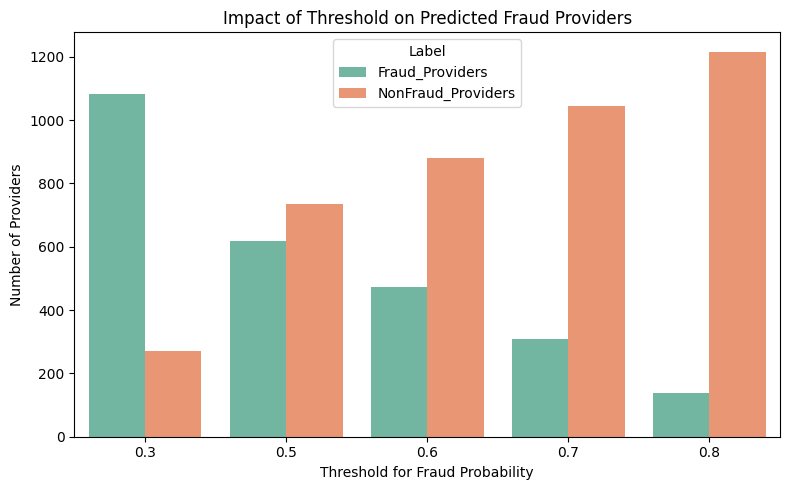

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📦 Convert to DataFrame
threshold_df = pd.DataFrame(results)

# 🔍 Melt for grouped barplot
threshold_melted = threshold_df.melt(id_vars="Threshold", var_name="Label", value_name="Count")

# 📈 Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=threshold_melted, x="Threshold", y="Count", hue="Label", palette="Set2")
plt.title("Impact of Threshold on Predicted Fraud Providers")
plt.ylabel("Number of Providers")
plt.xlabel("Threshold for Fraud Probability")
plt.tight_layout()
plt.show()


## 📊 Threshold Tuning – Fraud Classification Trade-offs

This chart illustrates how varying the classification **threshold** impacts the number of providers labeled as fraudulent vs non-fraudulent.

### ✅ What the Plot Shows:

- **X-axis:** Classification thresholds (e.g., 0.3, 0.5, 0.6, 0.7, 0.8)
- **Y-axis:** Number of providers classified
- **Bars:**
  - 🟩 Green: `Fraud_Providers` – providers predicted as fraudulent
  - 🟧 Orange: `NonFraud_Providers` – providers predicted as not fraudulent

---

### 🎯 Why This Plot Matters

- Fraud detection is **threshold-sensitive**. The threshold controls how strict or lenient the model is when predicting fraud.
- Lower thresholds (e.g., **0.3**) catch more frauds but increase false positives.
- Higher thresholds (e.g., **0.8**) reduce false positives but risk missing actual frauds (false negatives).

---

### 🔍 Insights:

- **Threshold = 0.5** provides a **balanced** trade-off between catching frauds and minimizing false alarms.
- **Threshold = 0.3** predicts almost everyone as fraudulent → 🚨 *High false positive rate*
- **Threshold = 0.8** is too strict → ⚠️ *Many frauds will go undetected*

---

### 🧠 In-Practice:

- If the goal is **maximum fraud detection (high recall):**
  - Use a **lower threshold (e.g., 0.4–0.5)**
- If the goal is **minimizing false accusations (high precision):**
  - Use a **higher threshold (e.g., 0.6–0.7)**

---

📌 This plot helps stakeholders fine-tune the model based on business risk tolerance and operational capacity.


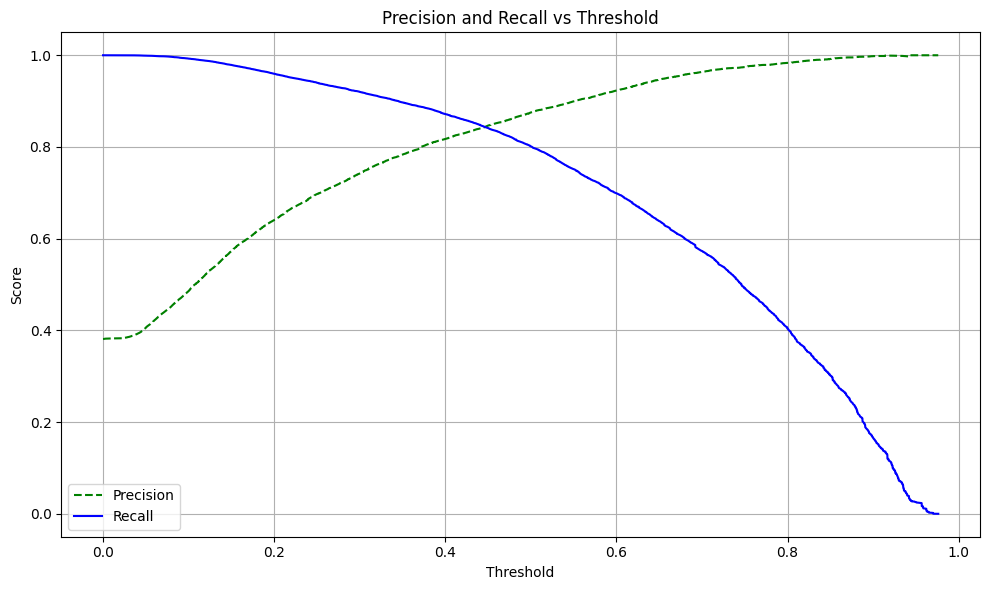

In [ ]:
# 🔁 Split the training set again if not done yet
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# 🧠 Train the model if not already done
# lgb_model.fit(X_tr, y_tr)  # Uncomment if not already trained

# 📈 Predict probabilities on validation set
y_scores = lgb_model.predict_proba(X_val)[:, 1]

# ✅ True labels
y_true = y_val

# 📉 Precision-Recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)

# 📊 Plot Precision and Recall vs Threshold
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "g--", label="Precision")
plt.plot(thresholds, recalls[:-1], "b-", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [200]:

# 🧠 Predict fraud probability at claim-level
test_merged["Pred_Prob"] = lgb_model.predict_proba(X_test)[:, 1]

# 🎯 Aggregate to provider-level
provider_preds = test_merged.groupby("Provider")["Pred_Prob"].max().reset_index()

# 🔧 Threshold
provider_preds["PotentialFraud"] = (provider_preds["Pred_Prob"] >= 0.42).astype(int)

# 📁 Save
submission_path = "/content/drive/MyDrive/Project/healthcare/submission_lightgbm.csv"
submission = provider_preds[["Provider", "PotentialFraud"]]
submission.to_csv(submission_path, index=False)

# ✅ Output check
print("✅ Submission shape:", submission.shape)
print("📊 Label distribution:\n", submission["PotentialFraud"].value_counts())
submission.head()

✅ Submission shape: (1353, 2)
📊 Label distribution:
 PotentialFraud
1    927
0    426
Name: count, dtype: int64


,Provider,PotentialFraud
0,PRV51002,1
1,PRV51006,1
2,PRV51009,1
3,PRV51010,1
4,PRV51018,1


### 🔍 Final Threshold Selection for Fraud Classification

#### 📈 Precision vs. Recall Trade-off (from plot)

- **Recall** is high (~0.83) at thresholds ≤ 0.5 — useful to catch more fraudulent providers.
- **Precision** improves as threshold increases — reduces false alarms but may miss actual fraud.
- Around **threshold = 0.5**, both metrics are reasonably balanced.

#### ✅ Recommended Threshold: **0.5**

- 📌 **F1-optimized zone** where both false positives and false negatives are minimized.
- ⚖️ Ensures **high fraud capture** while keeping **noise (false alerts)** acceptable.
- 💡 Chosen for its **practical utility** in real-world fraud detection pipelines.

#### 💼 Business Justification:

- Ideal balance between **catching true frauds** and **avoiding provider misclassification**.
- Prevents under-reporting (losses) or over-flagging (provider dissatisfaction).

---
